#### LSTM Model

From Wang et al.

In [1]:
import os
import numpy as np

import tensorflow as tf
print("TensorFlow version:", tf.__version__)

np.set_printoptions(precision=4)

TensorFlow version: 2.11.0


In [2]:
# Load in the RR interval data in segments of length 500
seg_length = 500

X = None # (N, 500)
y = None # (N, 2) -> one-hot encoded (1,0) or (0,1)

db1_pos = ['chfdb']
db1_neg = ['nsrdb', 'fantasia']
db2_pos = ['chf2db']
db2_neg = ['nsr2db']

for db in db1_pos:
    count = 0
    for record in os.listdir(f'data/{db}/rr'):
        rr = np.loadtxt(f'data/{db}/rr/{record}')
        n_segments = rr.shape[0] // seg_length
        rr = rr[:n_segments*seg_length].reshape((n_segments, seg_length))
        labels = np.c_[np.ones(n_segments), np.zeros(n_segments)]

        count += len(labels)
        if X is None or y is None:
            X = rr
            y = labels
        else:
            X = np.r_[rr, X]
            y = np.r_[labels, y]
    print(db, count)

for db in db1_neg:
    count = 0
    for record in os.listdir(f'data/{db}/rr'):
        rr = np.loadtxt(f'data/{db}/rr/{record}')
        n_segments = rr.shape[0] // seg_length
        rr = rr[:n_segments*seg_length].reshape((n_segments, seg_length))
        labels = np.c_[np.zeros(n_segments), np.ones(n_segments)]

        count += len(labels)
        if X is None or y is None:
            X = rr
            y = labels
        else:
            X = np.r_[rr, X]
            y = np.r_[labels, y]
    print(db, count)

X.shape, y.shape

chfdb 3240
nsrdb 3605
fantasia 552


((7397, 500), (7397, 2))

[0. 1.]


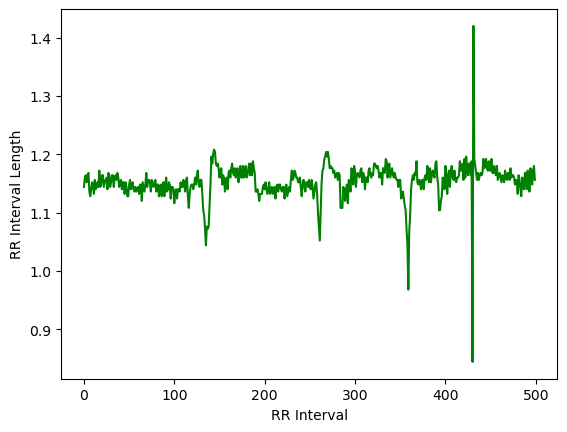

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

print(y[99])
plt.plot(X[99], color='g')
plt.yticks([0.9, 1.0, 1.1, 1.2, 1.3, 1.4])
plt.xlabel("RR Interval")
plt.ylabel("RR Interval Length")
plt.show()

# Plot of a segment from NSR class

[1. 0.]


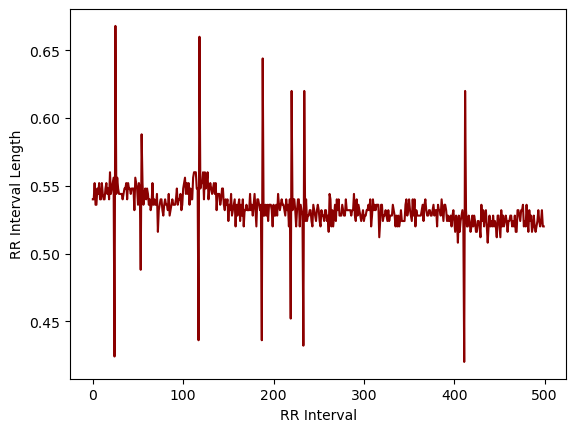

In [4]:
print(y[-3])
plt.plot(X[-3], color='darkred')
plt.yticks()
plt.xlabel("RR Interval")
plt.ylabel("RR Interval Length")
plt.show()

# Plot of a segment from CHF class

In [5]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X_raw = X.copy()
X = preprocessing.scale(X, axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=410)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.1, random_state=410)


_, X_test_raw, _, y_test_raw = train_test_split(
    X_raw, y, test_size=0.1, random_state=410)

X_train.shape, X_valid.shape, X_test.shape

((5991, 500), (666, 500), (740, 500))

In [6]:
X_train.max(), X_train.min()

(22.338093783952246, -19.73240054783729)

In [7]:
X_train.mean(), X_train.std()

(2.4321174537035673e-16, 1.0000000000000002)

In [8]:
inputs = tf.keras.layers.Input(shape=(500, 1))


def inception_lstm(inputs):
    a = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(5, return_sequences=True))(inputs)
    a = tf.keras.layers.LSTM(5, return_sequences=True)(a)

    b = tf.keras.layers.Conv1D(5, kernel_size=1, padding='same')(inputs)
    b = tf.keras.layers.Conv1D(5, kernel_size=3, padding='same')(b)

    c = tf.keras.layers.Conv1D(5, kernel_size=1, padding='same')(inputs)
    c = tf.keras.layers.Conv1D(5, kernel_size=5, padding='same')(c)

    d = tf.keras.layers.MaxPool1D(3)(inputs)
    d = tf.keras.layers.Conv1D(5, kernel_size=1)(d)

    concat = tf.keras.layers.Concatenate(1)([a, b, c, d])
    return concat


layer1 = inception_lstm(inputs)
layer2 = inception_lstm(layer1)
dropout = tf.keras.layers.Dropout(0.2)(layer2)
flattened = tf.keras.layers.Flatten()(dropout)
output = tf.keras.layers.Dense(2, activation='sigmoid')(flattened)

model = tf.keras.Model(inputs, output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500, 1)]     0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 500, 10)      280         ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 500, 5)       10          ['input_1[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 500, 5)       10          ['input_1[0][0]']                
                                                                                              

In [9]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

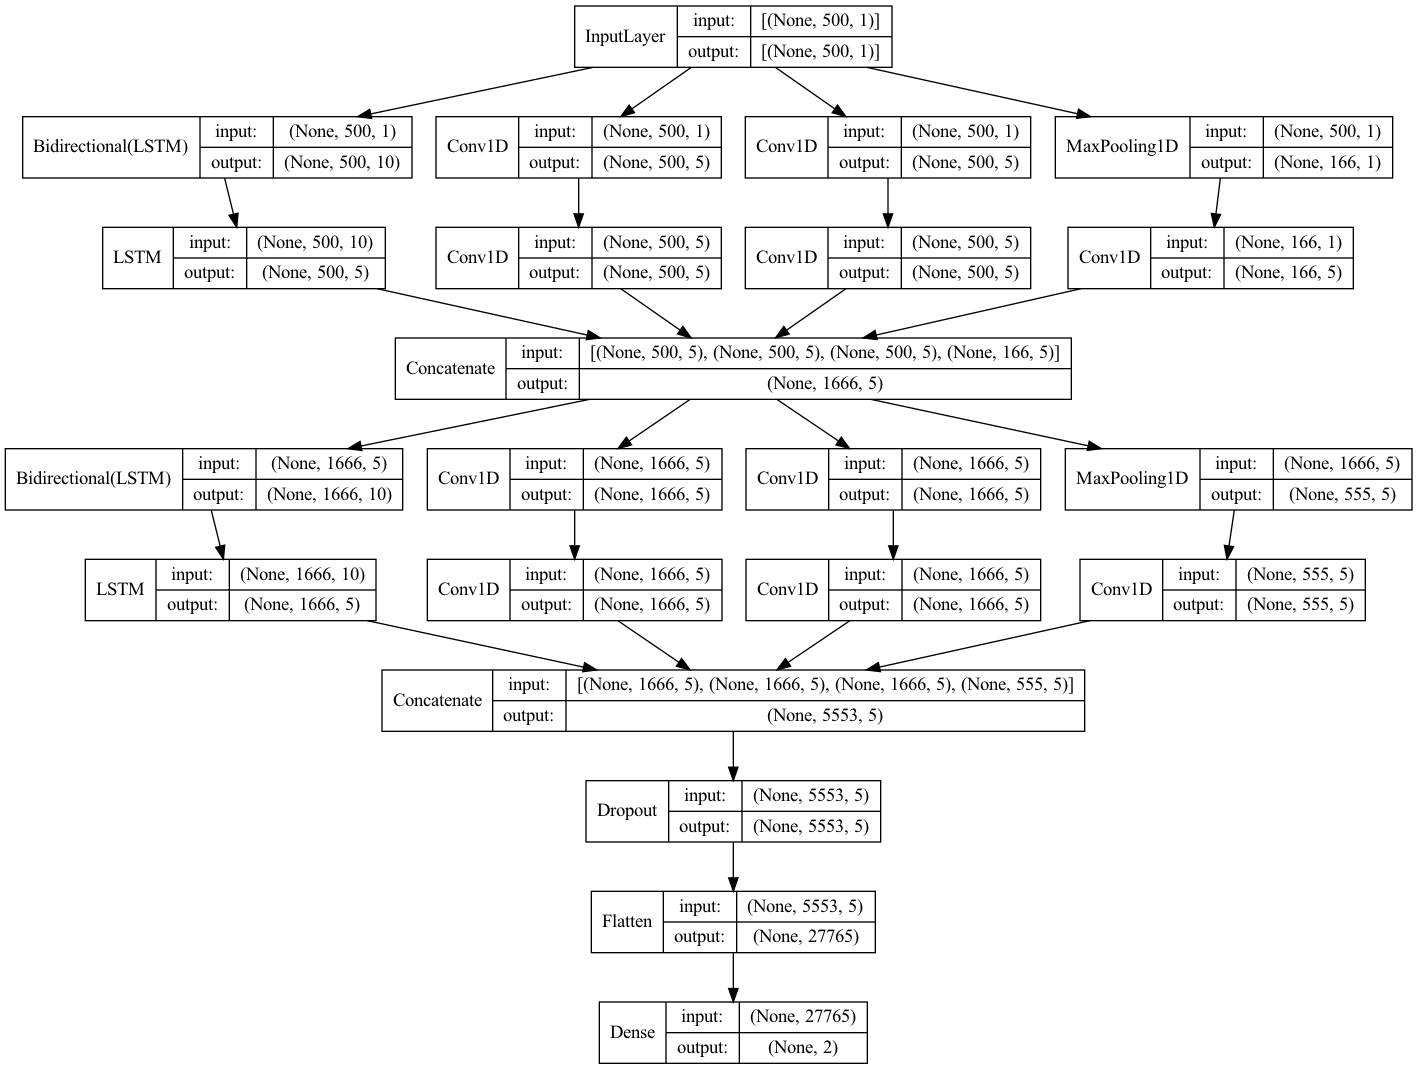

In [11]:
tf.keras.utils.plot_model(
    model,
    to_file='lstm-model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

In [ ]:
np.unique(y_test.argmax(axis=1), return_counts=True)

In [ ]:
# optional early-stopping callback
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.fit(x=X_train, y=y_train, validation_data=(X_valid, y_valid),
          batch_size=128, epochs=100)
model.save('lstm-model.keras')

In [ ]:
model = tf.keras.models.load_model('lstm-model.keras')
y_pred = model.predict(X_test)

In [ ]:
np.unique(y_pred.argmax(axis=1), return_counts=True)

In [ ]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

print(recall_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
print(precision_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
print(accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)))